<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

© Copyright Quantopian Inc.<br>
© Modifications Copyright QuantRocket LLC<br>
Licensed under the [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).<br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Quant Finance Lectures](Introduction.ipynb) › Lecture 12 - Linear Regression
***

# Linear Regression
By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie with example algorithms by David Edwards

Linear regression is a technique that measures the relationship between two variables. If we have an independent variable $X$, and a dependent outcome variable $Y$, linear regression allows us to determine which linear model $Y = \alpha + \beta X$ best explains the data. As an example, let's consider Apple (AAPL) and Home Depot (HD). We would like to know how AAPL varies as a function of how HD varies, so we will take the daily returns of each and regress them against each other.

Python's `statsmodels` library has a built-in linear fit function. Note that this will give a line of best fit; whether or not the relationship it shows is significant is for you to determine. The output will also have some statistics about the model, such as R-squared and the F value, which may help you quantify how good the fit actually is.

In [1]:
# Import libraries
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

/opt/conda/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


First we'll define a function that performs linear regression and plots the results.

In [2]:
def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model.summary()

Now we'll get pricing data on AAPL and MSFT and perform a regression.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     28.29
Date:                Tue, 25 May 2021   Prob (F-statistic):           2.33e-07
Time:                        14:40:15   Log-Likelihood:                 735.91
No. Observations:                 251   AIC:                            -1468.
Df Residuals:                     249   BIC:                            -1461.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.257      0.210      -0.001       0.003
x1             0.4147      0.078      5.318      0.000       0.261       0.568
==============================================================================
Omnibus:                       54.199   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              803.154
Skew:                          -0.224   Prob(JB):                    3.96e-175
Kurtosis:                      11.752   Cond. No.                         95.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

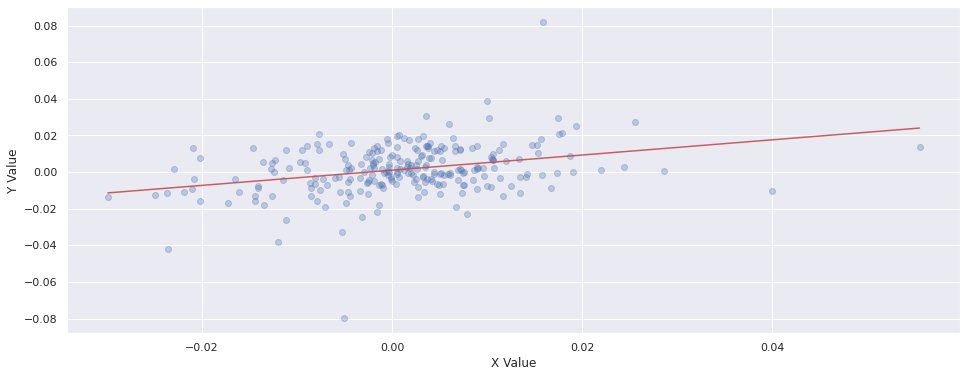

In [3]:
from quantrocket.master import get_securities
from quantrocket import get_prices

securities = get_securities(symbols=['AAPL', 'HD'], vendors='usstock')

start = '2014-01-01'
end = '2015-01-01'

closes = get_prices('usstock-free-1min', data_frequency='daily', sids=securities.index.tolist(), fields='Close', start_date=start, end_date=end).loc['Close']

sids_to_symbols = securities.Symbol.to_dict()
closes = closes.rename(columns=sids_to_symbols)

# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
aapl_returns = closes['AAPL'].pct_change()[1:]
hd_returns = closes['HD'].pct_change()[1:]

linreg(hd_returns.values, aapl_returns.values)

Each point on the above graph represents a day, with the x-coordinate being the return of HD, and the y-coordinate being the return of AAPL. As we can see, the line of best fit tells us that for every 1% increased return we see from the HD, we should see an extra 0.41% from AAPL. This is expressed by the parameter $\beta$, which is 0.4147 as estimated. Of course, for losses we will also see increased losses in AAPL, so we haven't gained anything, we are just more volatile.

## Linear Regression vs. Correlation

* Linear regression gives us a specific linear model, but is limited to cases of linear dependence.
* Correlation is general to linear and non-linear dependencies, but doesn't give us an actual model.
* Both are measures of covariance.
* Linear regression can give us relationship between Y and many independent variables by making X multidimensional.

## Knowing Parameters vs. Estimates

It is very important to keep in mind that all $\alpha$ and $\beta$ parameters estimated by linear regression are just that - estimates. You can never know the underlying true parameters unless you know the physical process producing the data. The parameters you estimate today may not be the same analysis done including tomorrow's data, and the underlying true parameters may be moving. As such it is very important when doing actual analysis to pay attention to the standard error of the parameter estimates. More material on the standard error will be presented in a later lecture. One way to get a sense of how stable your parameter estimates are is to estimate them using a rolling window of data and see how much variance there is in the estimates.


## Example case
Now let's see what happens if we regress two purely random variables.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8245
Date:                Tue, 25 May 2021   Prob (F-statistic):              0.366
Time:                        14:40:17   Log-Likelihood:                -23.432
No. Observations:                 100   AIC:                             50.86
Df Residuals:                      98   BIC:                             56.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4415      0.059      7.477      0.000       0.324       0.559
x1             0.0977      0.108      0.908      0.366      -0.116       0.311
==============================================================================
Omnibus:                       48.333   Durbin-Watson:                   2.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.110
Skew:                           0.145   Prob(JB):                       0.0286
Kurtosis:                       1.726   Cond. No.                         4.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

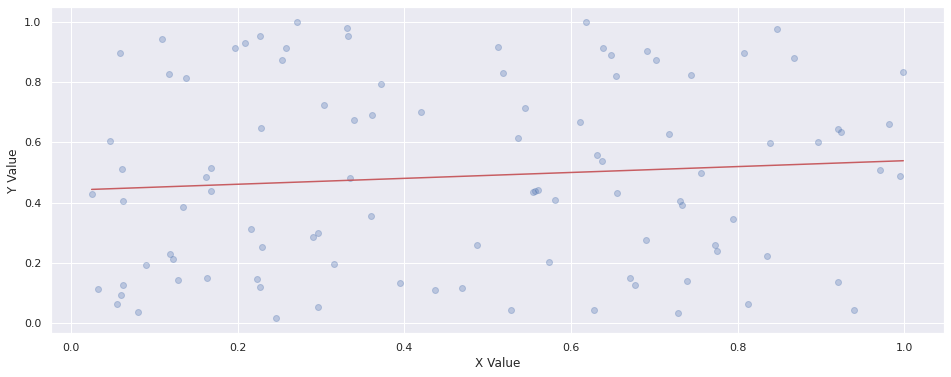

In [4]:
X = np.random.rand(100)
Y = np.random.rand(100)
linreg(X, Y)

The above shows a fairly uniform cloud of points. It is important to note that even with 100 samples, the line has a visible slope due to random chance. This is why it is crucial that you use statistical tests and not visualizations to verify your results.

Now let's make Y dependent on X plus some random noise.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     270.8
Date:                Tue, 25 May 2021   Prob (F-statistic):           5.88e-30
Time:                        14:40:19   Log-Likelihood:                 27.035
No. Observations:                 100   AIC:                            -50.07
Df Residuals:                      98   BIC:                            -44.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0283      0.036     -0.793      0.430      -0.099       0.042
x1             1.0692      0.065     16.455      0.000       0.940       1.198
==============================================================================
Omnibus:                        0.508   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.776   Jarque-Bera (JB):                0.453
Skew:                           0.161   Prob(JB):                        0.797
Kurtosis:                       2.928   Cond. No.                         4.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

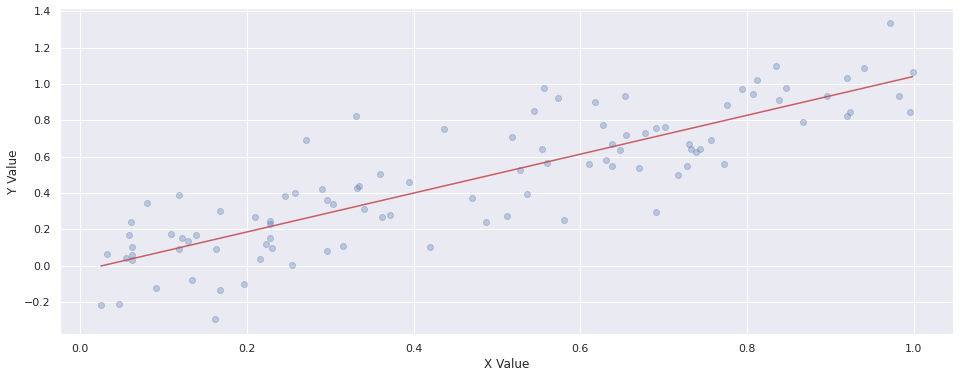

In [5]:
# Generate ys correlated with xs by adding normally-destributed errors
Y = X + 0.2*np.random.randn(100)

linreg(X,Y)

In a situation like the above, the line of best fit does indeed model the dependent variable Y quite well (with a high $R^2$ value).

## Evaluating and reporting results

The regression model relies on several assumptions:
* The independent variable is not random.
* The variance of the error term is constant across observations. This is important for evaluating the goodness of the fit.
* The errors are not autocorrelated. The Durbin-Watson statistic detects this; if it is close to 2, there is no autocorrelation.
* The errors are normally distributed. If this does not hold, we cannot use some of the statistics, such as the F-test.

If we confirm that the necessary assumptions of the regression model are satisfied, we can safely use the statistics reported to analyze the fit. For example, the $R^2$ value tells us the fraction of the total variation of $Y$ that is explained by the model.

When making a prediction based on the model, it's useful to report not only a single value but a confidence interval. The linear regression reports 95% confidence intervals for the regression parameters, and we can visualize what this means using the `seaborn` library, which plots the regression line and highlights the 95% (by default) confidence interval for the regression line:

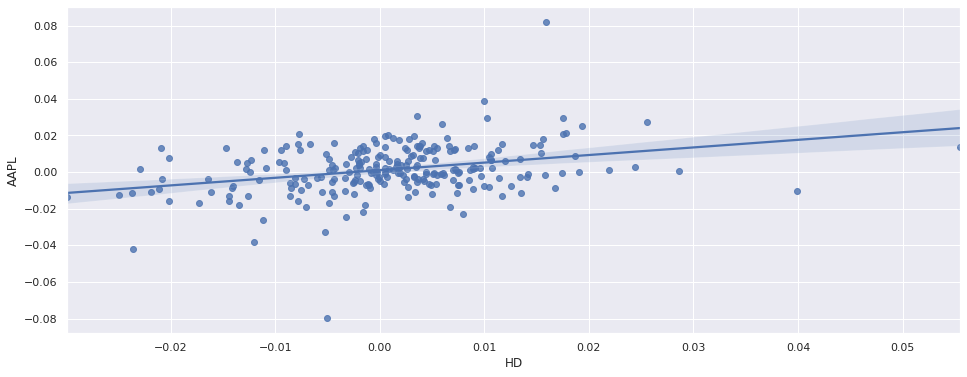

In [6]:
import seaborn
seaborn.regplot(x=hd_returns, y=aapl_returns);

## Mathematical Background

This is a very brief overview of linear regression. For more, please see:
https://en.wikipedia.org/wiki/Linear_regression

## Ordinary Least Squares

Regression works by optimizing the placement of the line of best fit (or plane in higher dimensions). It does so by defining how bad the fit is using an objective function. In ordinary least squares regression (OLS), what we use here, the objective function is:

$$\sum_{i=1}^n (Y_i - a - bX_i)^2$$

We use $a$ and $b$ to represent the potential candidates for $\alpha$ and $\beta$. What this objective function means is that for each point on the line of best fit we compare it with the real point and take the square of the difference. This function will decrease as we get better parameter estimates. Regression is a simple case of numerical optimization that has a closed form solution and does not need any optimizer. We just find the results that minimize the objective function.

We will denote the eventual model that results from minimizing our objective function as:

$$ \hat{Y} = \hat{\alpha} + \hat{\beta}X $$

With $\hat{\alpha}$ and $\hat{\beta}$ being the chosen estimates for the parameters that we use for prediction and $\hat{Y}$ being the predicted values of $Y$ given the estimates.

## Standard Error

We can also find the standard error of estimate, which measures the standard deviation of the error term $\epsilon$, by getting the `scale` parameter of the model returned by the regression and taking its square root. The formula for standard error of estimate is
$$ s = \left( \frac{\sum_{i=1}^n \epsilon_i^2}{n-2} \right)^{1/2} $$

If $\hat{\alpha}$ and $\hat{\beta}$ were the true parameters ($\hat{\alpha} = \alpha$ and $\hat{\beta} = \beta$), we could represent the error for a particular predicted value of $Y$ as $s^2$ for all values of $X_i$. We could simply square the difference $(Y - \hat{Y})$ to get the variance because $\hat{Y}$ incorporates no error in the parameter estimates themselves. Because $\hat{\alpha}$ and $\hat{\beta}$ are merely estimates in our construction of the model of $Y$, any predicted values , $\hat{Y}$, will have their own standard error based on the distribution of the $X$ terms that we plug into the model. This forecast error is represented by the following:

$$ s_f^2 = s^2 \left( 1 + \frac{1}{n} + \frac{(X - \mu_X)^2}{(n-1)\sigma_X^2} \right) $$

where $\mu_X$ is the mean of our observations of $X$ and $\sigma_X$ is the standard deviation of $X$. This adjustment to $s^2$ incorporates the uncertainty in our parameter estimates. Then the 95% confidence interval for the prediction is $\hat{Y} \pm t_cs_f$, where $t_c$ is the critical value of the t-statistic for $n$ samples and a desired 95% confidence.

---

**Next Lecture:** [Maximum Likelihood Estimation](Lecture13-Maximum-Likelihood-Estimation.ipynb) 

[Back to Introduction](Introduction.ipynb) 

---

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by QuantRocket LLC ("QuantRocket"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, the authors have not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information believed to be reliable at the time of publication. QuantRocket makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*